In [39]:
from multiclass_functions1 import *
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


In [40]:
import numpy as np
import random
random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed) # random seed 결정

In [41]:
BATCH_SIZE = 256
LR = 1e-3 # 10^-3
EPOCH = 10
NoB = 2 # layer 개수
NoC = 1 # node 개수 = 채널의 개수
criterion = nn.CrossEntropyLoss() # 분류 문제라서 CE
activation = "Sigmoid"
new_model_train = True
video_save = False
model_type = f"{activation}{NoB}C{NoC}"

In [42]:
transform = transforms.ToTensor()
train_DS = datasets.MNIST(root = '../data', train=True, download=True, transform=transform)
test_DS = datasets.MNIST(root = '../data', train=False, download=True, transform=transform)
train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

In [43]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        if activation == "Sigmoid":
            self.conv_block = nn.Sequential(
                nn.Conv2d(1,NoC,3, bias=False, padding=1),
                nn.Sigmoid(),
                *[i for j in range(NoB-1) for i in [nn.Conv2d(NoC,NoC,3, bias=False, padding=1), nn.Sigmoid()]]
                )
        elif activation == "BNSigmoid":
            self.conv_block = nn.Sequential(
                nn.Conv2d(1,NoC,3, bias=False, padding=1),
                nn.BatchNorm2d(NoC),
                nn.Sigmoid(),
                *[i for j in range(NoB-1) for i in [nn.Conv2d(NoC,NoC,3, bias=False, padding=1), nn.BatchNorm2d(NoC), nn.Sigmoid()]]
                )
        elif activation == "ReLU":
            self.conv_block = nn.Sequential(
                nn.Conv2d(1,NoC,3, bias=False, padding=1),
                nn.ReLU(),
                *[i for j in range(NoB-1) for i in [nn.Conv2d(NoC,NoC,3, bias=False, padding=1), nn.ReLU()]]
                )
        elif activation == "BNReLU":
            self.conv_block = nn.Sequential(
                nn.Conv2d(1,NoC,3, bias=False, padding=1),
                nn.BatchNorm2d(NoC),
                nn.ReLU(),
                *[i for j in range(NoB-1) for i in [nn.Conv2d(NoC,NoC,3, bias=False, padding=1), nn.BatchNorm2d(NoC), nn.ReLU()]]
                )
        self.maxpool1 = nn.MaxPool2d(2)
        self.maxpool2 = nn.MaxPool2d(2)
        self.fc = nn.Linear(NoC*7*7,10, bias=False) # 10개 분류이기 때문에 10개로 끝난다

    def forward(self, x):
        x = self.conv_block(x)
        x = self.maxpool1(x)
        x = self.maxpool2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

In [44]:
model=CNN().to(DEVICE)
print(model)
x_batch, _ = next(iter(train_DL))
print(model(x_batch.to(DEVICE)).shape)

CNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Sigmoid()
    (2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): Sigmoid()
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=49, out_features=10, bias=False)
)
torch.Size([256, 10])


In [45]:
def Train(model, train_DL, criterion):
    optimizer = optim.Adam(model.parameters(), lr=LR)

    loss_history=[]
    acc_history=[]
    mean_grad_history=[]
    mean_weight_history=[]

    NoT=len(train_DL.dataset) # The number of training data

    model.train() # train mode로 전환
    for ep in range(EPOCH):
        rloss = 0
        rcorrect = 0
        rgrad = torch.zeros(NoB+1) # grad 계산
        rweight = torch.zeros(NoB+1) # weight 계산
        for x_batch, y_batch in train_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            # inference
            y_hat = model(x_batch)
            # loss
            loss = criterion(y_hat, y_batch)
            # update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # loss accumulation
            loss_b = loss.item() * x_batch.shape[0]
            rloss += loss_b
            # accuracy accumulation
            pred = y_hat.argmax(dim=1)
            corrects_b = torch.sum(pred == y_batch).item()
            rcorrect += corrects_b
            # grad and weight (batch)
            with torch.no_grad():
                wlist = [m.weight for m in model.modules() if isinstance(m,nn.Conv2d) or isinstance(m,nn.Linear)]
                rgrad += torch.tensor([w.grad.abs().sum() * x_batch.shape[0] / w.numel() for w in wlist])
                # gradient에 절대값을 취하고, 합산 = layer별 gradient를 합산하여 저장
                rweight += torch.tensor([w.abs().sum() / w.numel() for w in wlist])
                # wieght에 절대값을 취하고, 합산
        # break
        # grad and weight (epoch)
        mean_grad_history += [rgrad/NoT] # train 데이터 개수 (NoT)로 나눠주어 평균을 구함
        # grad 합산시 x_batch.shape[0]를 곱해주었기 때문에 전체 데이터 개수로 나눈 것
        mean_weight_history += [rweight/len(train_DL)] # len(train_DL) = Batch 수 (=총 데이터 개수/배치사이즈) 로 나눔
        # batch size가 하나 들어갔을 때, weight 하나 나옴 => weight 묶음 개수는 = Batch 수 > 그래서 평균내줄 때 Batch 수로 하는 것
        # 근데 그냥 weight도 위에 곱해버리고, NoT로 나눠버리면 안되나..?

        loss_e = rloss/NoT # epoch loss
        accuracy_e = rcorrect/NoT * 100
        loss_history += [loss_e]
        acc_history += [accuracy_e]
        print(f"Epoch: {ep+1}, train loss: {round(loss_e,3)}, train accuracy: {round(accuracy_e,1)} %")
        print("-"*20)

    return loss_history, acc_history, mean_grad_history, mean_weight_history

In [46]:
if new_model_train:
    loss_history, acc_history, mean_grad_history, mean_weight_history  = Train(model, train_DL, criterion)

Epoch: 1, train loss: 2.298, train accuracy: 12.5 %
--------------------
Epoch: 2, train loss: 2.158, train accuracy: 47.6 %
--------------------
Epoch: 3, train loss: 1.827, train accuracy: 65.9 %
--------------------
Epoch: 4, train loss: 1.55, train accuracy: 69.6 %
--------------------
Epoch: 5, train loss: 1.353, train accuracy: 71.7 %
--------------------
Epoch: 6, train loss: 1.211, train accuracy: 73.1 %
--------------------
Epoch: 7, train loss: 1.105, train accuracy: 74.3 %
--------------------
Epoch: 8, train loss: 1.023, train accuracy: 75.2 %
--------------------
Epoch: 9, train loss: 0.958, train accuracy: 76.1 %
--------------------
Epoch: 10, train loss: 0.906, train accuracy: 76.9 %
--------------------


Test accuracy: 7824/10000 (78.2 %)
508


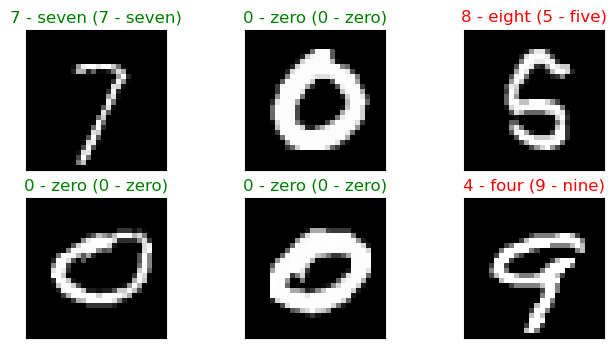

In [62]:
test_acc = Test(model, test_DL)
print(count_params(model))
Test_plot(model, test_DL)

실제값 (예측값)

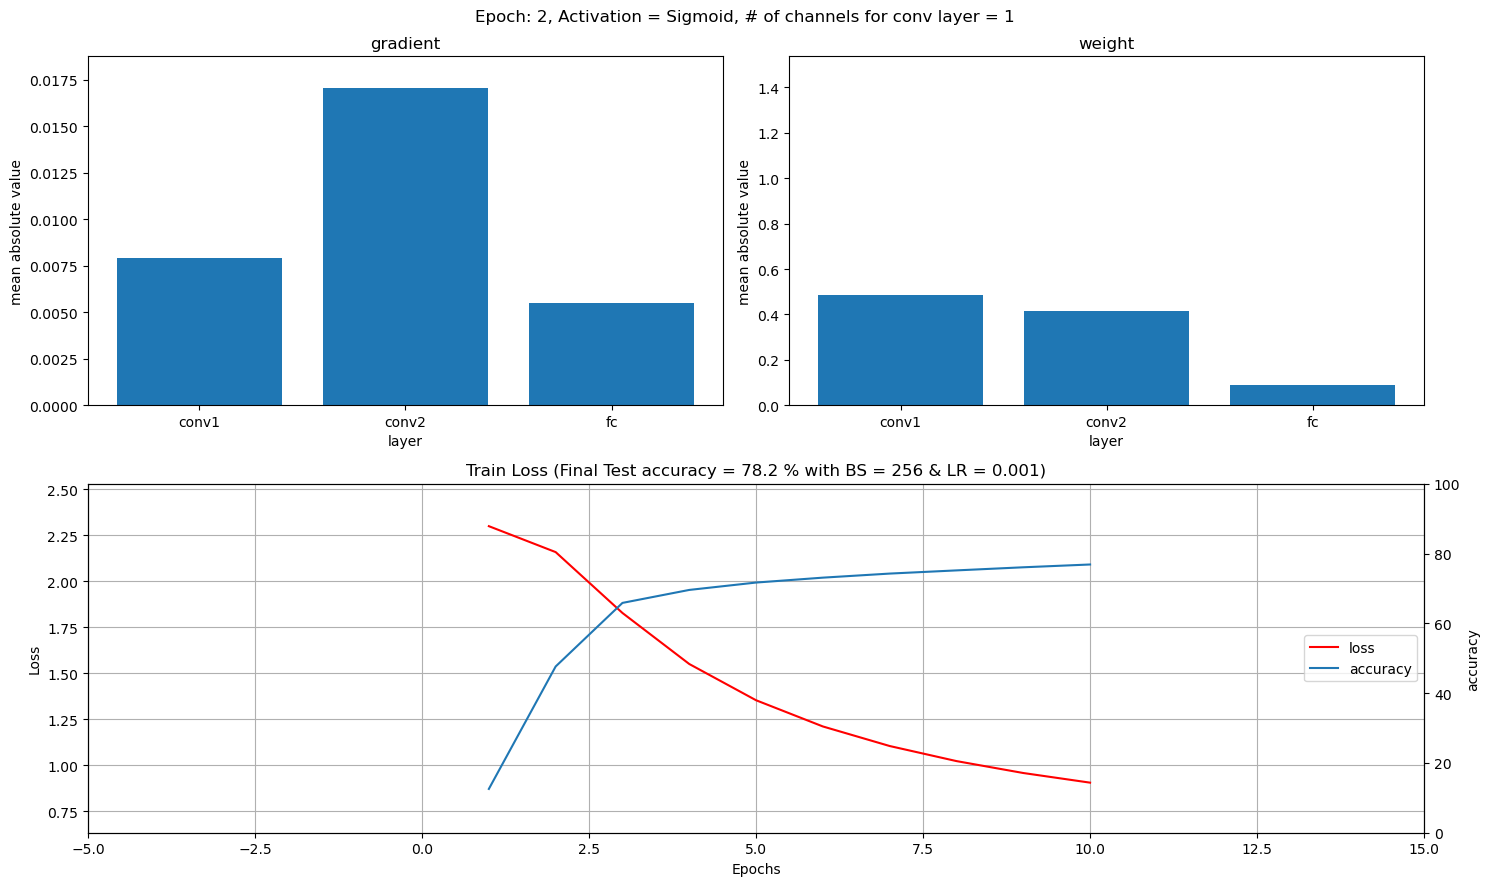

In [63]:
fig = plt.figure(figsize=[15, 9])
ymax_grad = max([i.max().item() for i in mean_grad_history])*1.1
ymax_weight = max([i.max().item() for i in mean_weight_history])*1.1
i = 1

plt.suptitle(f"Epoch: {range(1,EPOCH+1)[i]}, Activation = {activation}, # of channels for conv layer = {NoC}")

# 평균 grad 값
plt.subplot(2,2,1)
x_axis = [f"conv{i}" for i in range(1,NoB+1)]+["fc"]
plt.bar(x_axis,mean_grad_history[i].cpu(), width=0.8)
plt.ylim([0,ymax_grad])
plt.xlabel("layer")
plt.ylabel("mean absolute value")
plt.title("gradient")

# 평균 weight 값
plt.subplot(2,2,2)
x_axis = [f"conv{i}" for i in range(1,NoB+1)]+["fc"]
plt.bar(x_axis,mean_weight_history[i].cpu(), width=0.8)
plt.ylim([0,ymax_weight])
plt.xlabel("layer")
plt.ylabel("mean absolute value")
plt.title("weight")

ax1 = plt.subplot(2,1,2)
ax2 = ax1.twinx()
p1=ax1.plot(range(1,EPOCH+1),loss_history,'r')
p2=ax2.plot(range(1,EPOCH+1),acc_history)
ax1.set_xlim([-5,EPOCH+5])
ax1.set_ylim([min(loss_history)*0.7, max(loss_history)*1.1])
ax2.set_ylim([0, 100])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax2.set_ylabel("accuracy")
ax1.set_title(f"Train Loss (Final Test accuracy = {test_acc} % with BS = {BATCH_SIZE} & LR = {LR})")
ax1.grid()
plt.legend(p1+p2,["loss", "accuracy"], loc="right")

plt.tight_layout()

conv, conv2, fc 순으로 layer >>
1. 첫 번째 fig는 gradient에 대한 각 layer 평균값
- 만약 vanishing gradieng이라면, 입력층으로 갈수록 gradient가 작아지는 양상을 보일 것
2. 두 번째 fig는 weight에 대한 각 layer 평균값

# case 확인

<img src="image/layer3_init.png" width="800">
<img src="image/layer3.png" width="800">

layer 3 & node 1개의 초기단계와 epoch 100의 단계
- vanising gradient X

<img src="image/layer10_init.png" width="800">
<img src="image/layer10.png" width="800">

layer 10 & node 1개의 초기단계와 epoch 100의 단계
- vanising gradient O

`layer를 늘릴수록 gradient가 사라지는 현상`

<img src="image/relu_init.png" width="800">
<img src="image/relu.png" width="800">

acitivation RELU & layer 10 & node 1개의 초기단계와 epoch 100의 단계
- vanising gradient X

`Acivation만 RELU로 바꿨을 뿐인데, gradient 살아있는 것을 볼 수 있음`

<img src="image/relu_c10_init.png" width="800">
<img src="image/relu_c10.png" width="800">

acitivation RELU & layer 10 & node 10개의 초기단계와 epoch 100의 단계
- vanising gradient X

`channel (=node) 수를 늘렸을 때도 마찬가지로 gradient가 살아있다!`

<img src="image/layer10_c10.png" width="800">
<img src="image/relu_c10.png" width="800">

layer 10 & node 10은 동일 acitivation sigmoid와 RELU 차이 비교

`동일한 조건에서 sigmoid는 거의 학습이 안되는 것을 볼 수 있고, 이와 반대로 RELU는 gradient가 살아 학습이 제대로 되는 것을 볼 수 있음`